# Simple MNIST Neural Network from scratch

In this notebook, I implemented a simple two-layer neural network and trained it on the MNIST digit recognizer dataset. It's meant to be an instructional example, through which you can understand the underlying math of neural networks better.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data=pd.read_csv("mnist_train.csv")

This line reads the MNIST dataset from a CSV file named "train.csv" using Pandas and stores it in a DataFrame called data.

In [3]:
data.head()

,5,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.608,0.609,0.610,0.611,0.612,0.613,0.614,0.615,0.616,0.617
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


These lines convert the DataFrame into a NumPy array, shuffling the data to ensure randomness, and retrieve the number of rows m and the number of columns n.

In [4]:
data=np.array(data)
m, n= data.shape
np.random.shuffle(data)

data_dev=data[0:1000].T
Y_dev=data_dev[0]
X_dev=data_dev[1:n]
X_dev = X_dev / 255.

data_train=data[1000:m].T
Y_train=data_train[0]
X_train=data_train[1:n]
X_train = X_train / 255.
_,m_train = X_train.shape

Here, the data is split into a development set (data_dev) and a training set (data_train). The pixel values are normalized to a range between 0 and 1 by dividing by 255.

Our NN will have a simple two-layer architecture. Input layer $a^{[0]}$ will have 784 units corresponding to the 784 pixels in each 28x28 input image. A hidden layer $a^{[1]}$ will have 10 units with ReLU activation, and finally our output layer $a^{[2]}$ will have 10 units corresponding to the ten digit classes with softmax activation.

**Forward propagation**

$$Z^{[1]} = W^{[1]} X + b^{[1]}$$
$$A^{[1]} = g_{\text{ReLU}}(Z^{[1]}))$$
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$$
$$A^{[2]} = g_{\text{softmax}}(Z^{[2]})$$

**Backward propagation**

$$dZ^{[2]} = A^{[2]} - Y$$
$$dW^{[2]} = \frac{1}{m} dZ^{[2]} A^{[1]T}$$
$$dB^{[2]} = \frac{1}{m} \Sigma {dZ^{[2]}}$$
$$dZ^{[1]} = W^{[2]T} dZ^{[2]} .* g^{[1]\prime} (z^{[1]})$$
$$dW^{[1]} = \frac{1}{m} dZ^{[1]} A^{[0]T}$$
$$dB^{[1]} = \frac{1}{m} \Sigma {dZ^{[1]}}$$

**Parameter updates**

$$W^{[2]} := W^{[2]} - \alpha dW^{[2]}$$
$$b^{[2]} := b^{[2]} - \alpha db^{[2]}$$
$$W^{[1]} := W^{[1]} - \alpha dW^{[1]}$$
$$b^{[1]} := b^{[1]} - \alpha db^{[1]}$$

**Vars and shapes**

Forward prop

- $A^{[0]} = X$: 784 x m
- $Z^{[1]} \sim A^{[1]}$: 10 x m
- $W^{[1]}$: 10 x 784 (as $W^{[1]} A^{[0]} \sim Z^{[1]}$)
- $B^{[1]}$: 10 x 1
- $Z^{[2]} \sim A^{[2]}$: 10 x m
- $W^{[1]}$: 10 x 10 (as $W^{[2]} A^{[1]} \sim Z^{[2]}$)
- $B^{[2]}$: 10 x 1

Backprop

- $dZ^{[2]}$: 10 x m ($~A^{[2]}$)
- $dW^{[2]}$: 10 x 10
- $dB^{[2]}$: 10 x 1
- $dZ^{[1]}$: 10 x m ($~A^{[1]}$)
- $dW^{[1]}$: 10 x 10
- $dB^{[1]}$: 10 x 1

In [59]:
def init_params():
    w1=np.random.rand(10,784)-0.5
    b1=np.random.rand(10,1)-0.5
    w2=np.random.rand(10,10)-0.5
    b2=np.random.rand(10,1)-0.5
    return w1, b1, w2, b2

This function initializes the parameters of the neural network: weights (w1, w2) and biases (b1, b2) for the input and hidden layers.

In [60]:
def ReLU(Z):
    return np.maximum(Z, 0)

In [61]:
def softmax(Z):
    A=np.exp(Z) / sum(np.exp(Z))
    return A

These functions define the activation functions used in the neural network: ReLU (Rectified Linear Unit) for the hidden layer and softmax for the output layer.

In [62]:
def forward_prop(w1, b1, w2, b2, X):
    z1=w1.dot(X)+b1
    a1=ReLU(z1)
    z2=w2.dot(a1)+b2
    a2=softmax(z2)
    return z1, a1, z2, a2

This function performs forward propagation, computing the activations of each layer sequentially until the final output is obtained.

In [63]:
def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

In [64]:
def deriv_ReLU(Z):
    return Z>0

In [65]:
def back_prop(z1, a1, z2, a2, w2, Y, X):
    OneHot_Y=one_hot(Y)
    dZ2=a2-OneHot_Y
    dW2=1/m * dZ2.dot(a1.T)
    db2=1/m * np.sum(dZ2)
    dZ1=w2.T.dot(dZ2)*deriv_ReLU(z1)
    dW1=1/m * dZ1.dot(X.T)
    db1=1/m * np.sum(dZ1)
    return dW1, db1, dW2, db2

This function computes the gradients of the loss function with respect to the parameters of the network during backpropagation.

In [66]:
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1=W1-alpha*dW1
    b1=b1-alpha*db1
    W2=W2-alpha*dW2
    b2=b2-alpha*db2
    return W1, b1, W2, b2

This function updates the parameters of the neural network using gradient descent.

In [67]:
def get_predictions(a2):
    return np.argmax(a2,0)

In [68]:
def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y)/Y.size

In [69]:
def gradient_descent(X, Y, iterations, alpha):
    w1, b1, w2, b2=init_params()
    for i in range(iterations):
        z1, a1, z2, a2 =forward_prop(w1, b1, w2, b2, X)
        dW1, db1, dW2, db2 = back_prop(z1, a1, z2, a2, w2, Y, X)
        w1, b1, w2, b2 = update_params(w1, b1, w2, b2, dW1, db1, dW2, db2, alpha)
        if i%10==0:
            print("iterations: ",i)
            print("accuracy: ",get_accuracy(get_predictions(a2),Y))
    return w1, b1, w2, b2

This function performs gradient descent to train the neural network, iterating over a specified number of epochs (iterations) and updating the parameters.

In [70]:
w1, b1, w2, b2=gradient_descent(X_train, Y_train, 500, 0.1)

iterations:  0
[7 7 7 ... 4 7 7] [3 6 5 ... 7 7 7]
accuracy:  0.09332361565450262
iterations:  10
[7 6 7 ... 1 6 7] [3 6 5 ... 7 7 7]
accuracy:  0.16362989203206835
iterations:  20
[7 6 7 ... 1 6 7] [3 6 5 ... 7 7 7]
accuracy:  0.21310530686960796
iterations:  30
[0 6 7 ... 1 6 7] [3 6 5 ... 7 7 7]
accuracy:  0.248478787776064
iterations:  40
[0 6 7 ... 1 4 7] [3 6 5 ... 7 7 7]
accuracy:  0.2875811454431431
iterations:  50
[0 6 7 ... 1 4 2] [3 6 5 ... 7 7 7]
accuracy:  0.3327853014457872
iterations:  60
[5 6 1 ... 1 4 2] [3 6 5 ... 7 7 7]
accuracy:  0.3869896099933897
iterations:  70
[5 6 1 ... 1 4 7] [3 6 5 ... 7 7 7]
accuracy:  0.4399566094340582
iterations:  80
[5 6 1 ... 7 4 7] [3 6 5 ... 7 7 7]
accuracy:  0.4891099849149986
iterations:  90
[5 6 1 ... 7 4 7] [3 6 5 ... 7 7 7]
accuracy:  0.5297038932863268
iterations:  100
[5 6 1 ... 7 4 7] [3 6 5 ... 7 7 7]
accuracy:  0.5640095594840591
iterations:  110
[5 6 1 ... 7 4 7] [3 6 5 ... 7 7 7]
accuracy:  0.5943151578840319
iterations:  

~86% accuracy on training set.

In [72]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

This function makes predictions using the trained neural network.

In [73]:
def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

These functions are for testing predictions and calculating accuracy on the validation set.

Let's look at a couple of examples:

Prediction:  [5]
Label:  3


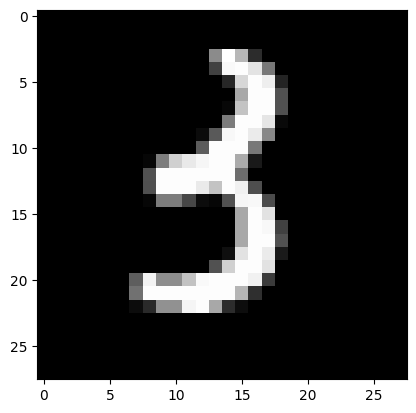

Prediction:  [6]
Label:  6


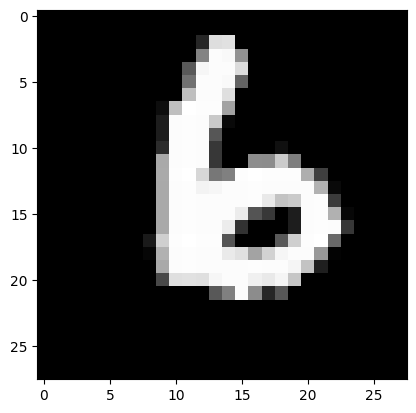

Prediction:  [5]
Label:  5


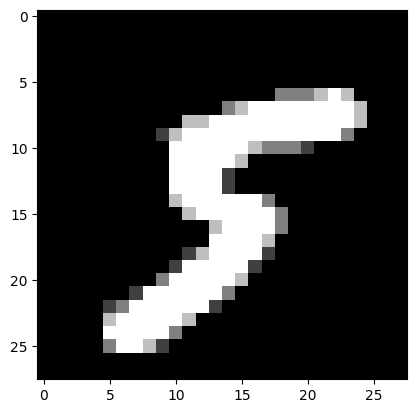

Prediction:  [8]
Label:  8


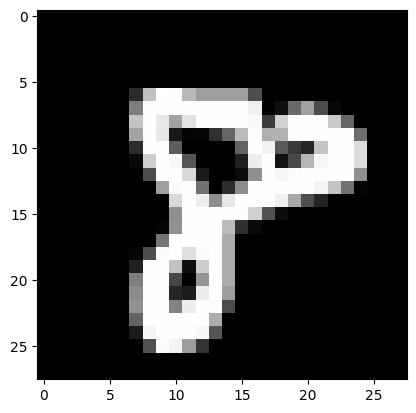

In [74]:
test_prediction(0, w1, b1, w2, b2)
test_prediction(1, w1, b1, w2, b2)
test_prediction(2, w1, b1, w2, b2)
test_prediction(3, w1, b1, w2, b2)

Finally, let's find the accuracy on the dev set:

In [75]:
dev_predictions = make_predictions(X_dev, w1, b1, w2, b2)
get_accuracy(dev_predictions, Y_dev)

[3 3 1 6 1 3 4 6 1 9 9 0 5 9 6 0 6 9 0 9 9 3 0 7 7 4 3 6 7 4 2 4 4 1 7 6 3
 8 3 6 7 6 7 1 7 4 5 2 0 0 7 0 4 8 6 3 3 5 7 0 5 9 5 4 0 0 7 0 2 3 0 6 4 4
 9 6 4 9 5 2 5 4 6 7 2 5 4 9 7 1 0 1 8 8 4 7 1 0 1 4 4 0 1 4 8 4 7 2 9 6 7
 0 8 8 4 3 7 6 6 2 5 9 2 0 2 5 5 2 0 0 8 6 6 9 1 6 6 6 7 8 7 1 2 5 2 6 6 8
 2 0 1 3 2 0 7 1 6 5 4 7 7 2 9 1 5 1 8 6 1 3 4 8 1 2 4 4 6 3 1 0 8 2 0 8 3
 4 3 9 8 9 6 7 3 3 9 0 2 6 6 1 6 0 4 3 0 3 6 9 5 0 2 0 5 2 5 6 1 3 2 4 4 6
 7 5 0 6 4 3 7 2 0 1 0 4 2 3 6 6 9 7 8 4 9 5 9 4 7 9 4 6 8 0 9 1 8 1 6 7 9
 0 4 0 3 1 1 5 0 6 7 7 6 1 7 7 9 5 7 1 8 7 3 4 1 2 1 0 2 0 8 1 8 5 3 7 9 7
 7 7 3 2 0 9 5 2 3 1 4 7 0 8 3 9 4 3 3 7 3 3 3 4 2 9 8 3 6 2 4 5 5 0 7 9 0
 8 3 1 9 6 7 8 2 5 5 3 2 4 9 1 9 4 7 7 4 0 2 0 9 3 3 9 2 0 0 8 0 2 9 3 2 3
 3 5 3 4 9 5 1 0 9 9 3 5 9 3 3 4 3 6 3 3 0 4 6 2 1 9 2 4 6 4 2 2 7 3 1 9 1
 9 1 6 8 1 4 4 7 5 4 3 8 6 2 7 9 1 9 6 6 1 6 2 2 1 9 5 4 1 0 4 7 2 7 6 2 7
 9 7 8 9 0 0 3 0 9 9 7 5 0 4 0 8 4 4 2 1 9 4 3 3 1 8 3 6 9 9 1 1 8 1 6 8 4
 5 6 2 8 2 1 3 3 7 2 3 2 

np.float64(0.828)

Still 85% accuracy, so our model generalized from the training data pretty well.

Code by Om Baval 
For any further clarification you can drop me a mail on ombaval@gmail.com